# Deep Learning: Image Captioning

In [2]:
#!pip install multiprocess
#!pip install torchsummary
#!pip install nltk
#!pip install torchtext
#!pip install spacy

In [3]:
import sys
sys.path.append('..')
import os
import shutil
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle
import nltk

import program.model
import program.data

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torchtext.data.metrics import bleu_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# Data

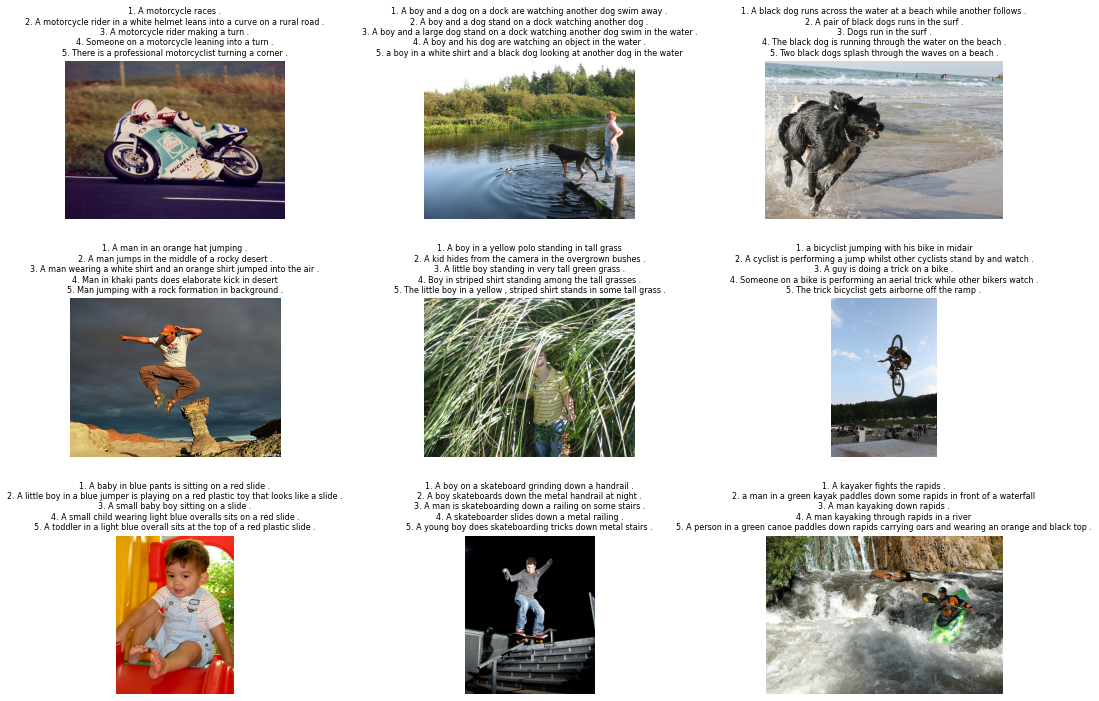

In [4]:
program.data.show_random_images(image_dir='./data/Images', captions_path='./data/captions.txt', count=9)

**Beschreibung:**

Das Bild zeigt einige Beispielbilder mit den dazugehörigen Captions. Pro Bild gibt es grundsätzlich 5 verschiedene Captions.

In [5]:
image_captions = pd.read_table('./data/captions.txt', sep=',')
image_captions.head(2)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .


Der Datensatz mit den Captions kann als CSV eingelesen werden. Pro Bild exisiteren mehrere Captions.

## Generate Train-Validate-Test

In [6]:
def generate_image_splits(image_folder, test_size=1000, validation_size=1000):
    images = np.array(os.listdir('./data/Images/'))
    np.random.shuffle(images)
    train_size = images.shape[0] - validation_size - test_size
    train_images = images[:train_size]
    assert len(train_images) == train_size
    images = images[train_size:]

    test_images = images[:test_size]
    assert len(test_images) == test_size
    images = images[test_size:]

    validation_images = images
    assert len(validation_images) == validation_size
    
    return (train_images, validation_images, test_images)

In [7]:
train_images, validation_images, test_images = generate_image_splits(image_folder='./data/Images/', 
                                                                     test_size=1000, validation_size=1000)

# prepare files to copy with multiprocessing
train_images = ['./data/Images/'+img for img in train_images]
train_images = [img + '__' + './data/train/' + img.split('/')[-1] for img in train_images]

validation_images = ['./data/Images/'+img for img in validation_images]
validation_images = [img + '__' + './data/val/' + img.split('/')[-1] for img in validation_images]

test_images = ['./data/Images/'+img for img in test_images]
test_images = [img + '__' + './data/test/' + img.split('/')[-1] for img in test_images]

In [8]:
# Check if works
function_check = False
if function_check:
    amount_test_images = 100
    test_img = train_images[:amount_test_images]
    program.data.copy_all_files(fp_from_to=test_img)

    for img in tqdm(test_img, desc='Deleting Images again'):
        assert os.path.isfile(img.split('__')[-1])
        os.remove(img.split('__')[-1])

In [9]:
copy_files = False
if copy_files:
    program.data.copy_all_files(fp_from_to=train_images)
    program.data.copy_all_files(fp_from_to=validation_images)
    program.data.copy_all_files(fp_from_to=test_images)

In [10]:
save_caps_per_split = False

if save_caps_per_split:
    train_caps = image_captions[image_captions['image'].isin(os.listdir('./data/train/'))]
    assert 5*len(os.listdir('./data/train/')) == train_caps.shape[0]
    train_caps.to_csv('./data/train_captions.csv', index=False)

    val_caps = image_captions[image_captions['image'].isin(os.listdir('./data/val/'))]
    assert 5*len(os.listdir('./data/val/')) == val_caps.shape[0]
    val_caps.to_csv('./data/val_captions.csv', index=False)

    test_caps = image_captions[image_captions['image'].isin(os.listdir('./data/test/'))]
    assert 5*len(os.listdir('./data/test/')) == test_caps.shape[0]
    test_caps.to_csv('./data/test_captions.csv', index=False)

## Preprocess Text-Data


In [11]:
from multiprocess import Pool
import re
from collections import Counter

In [12]:
class TextPreprocessor(object):
    """Class handles text data."""
    
    def __init__(self, n_processes, 
                 start_token='<START>', end_token='<END>', fill_token='<PAD>', unknown_token='<UNK>',
                 pad_fill=True, disable_pbar=True):
        """
        Handles text from csvs, extract tokens with padding or without. Can create a dictionary with words
        to idx.        
        """
        self.n_processes = n_processes
        self.start_token = start_token
        self.end_token = end_token
        self.fill_token = fill_token
        self.pad_fill = pad_fill
        self.unknown_token = unknown_token
        self.disable_pbar = disable_pbar
        self.longest_word = None
        self.tokenized_text = None
        self.text_dict = None
        self.text_dict_r = None
    
    @staticmethod
    def _longest_word(X):
        """Extracts longest word from all given sentences"""
        X_ = pd.Series(X)
        longest_word = np.max(X_.map(lambda x: len(x.split(' '))))
        
        return longest_word

    def tokenize(self, X, return_tokenized=False):
        """Tokenizes Sentence by the help of multiprocessing"""
        self.longest_word = self._longest_word(X=X)
        
        def __tokenize_words(s):
            s = re.sub(pattern=r'[^\w\s]', repl='', string=s)
            s = s.lower()
            w = s.split(' ')[:-1]   
            w.append(self.end_token)
            if self.pad_fill:
                while len(w) < self.longest_word:
                    w.append('<PAD>')
            w.insert(0, self.start_token)
            
            return w
        
        with Pool(processes=self.n_processes) as pool:
            tokenized_text = pool.map(__tokenize_words, X)
        
        self.tokenized_text = tokenized_text
        
        if return_tokenized:
            return tokenized_text
    
    def create_txt_dict(self):
        """Creates a dictionary object which can be used to translate from word to idx"""
        self.text_dict = {self.start_token:1, self.end_token:2, self.unknown_token:3}
        idx = 4
        if self.pad_fill:
            self.text_dict[self.fill_token] = idx
            idx += 1
            
        for text in self.tokenized_text:
            for word in text:
                if not self.text_dict.get(word):
                    self.text_dict[word] = idx
                    idx += 1
            
        return self
    
    def idx_to_word(self, idx: list):
        """Creates a reverse dictionary which can be used to translate from idx back to word"""
        if not self.text_dict:
            self.create_txt_dict()
        
        # Create dict to transform words back
        if not self.text_dict_r:
            self.text_dict_r = dict(zip(list(self.text_dict.values()), list(self.text_dict.keys())))
        
        return ' '.join([self.text_dict_r[id_] for id_ in idx.tolist()])
    
    def word_to_idx(self, word):
        """Takes a word and returns its index"""
        if not self.text_dict:
            self.create_txt_dict()
        
        return self.text_dict[word]
    
    def count_words(self):
        """Counts length of tokenized sentences."""
        concat_lists = []

        for L in tqdm(processor.tokenized_text, disable=self.disable_pbar):
            for element in L:
                concat_lists.append(element)
                
        return Counter(concat_lists)
    
class TextHandler(TextPreprocessor):
    
    def __init__(self, n_processes: int, unknown_threshold: float = None, start_token: str ='<START>', 
                 end_token: str ='<END>', fill_token: str='<PAD>', unknown_token: str ='<UNK>', pad_fill: bool =True, disable_pbar=True):
        """
        
        arguments:
        ------------------
        n_processes: int
            Amount processed to use for the tokenization
            
        unknown_threshold: int or float
            Less frequent words to remove from data
            
        start_token: str
            default: '<START>' Start token
        
        end_token: str
            default: '<END>', End token
        
        fill_token: str 
            default:'<PAD>', Pad token
        
        unknown_token: str
            default:'<UNK>', unknown token
        
        pad_fill: bool
            default=True, add_idx_for_new_word=False
        """
        super().__init__(n_processes=n_processes, start_token=start_token, end_token=end_token, 
                         fill_token=fill_token, unknown_token=unknown_token, pad_fill=pad_fill, 
                         disable_pbar=disable_pbar)
        self.unknown_threshold = unknown_threshold
        self.disable_pbar = disable_pbar
        
        
    def fit(self, X: list):
        """"""
        self.tokenize(X, return_tokenized=False)
        self.create_txt_dict()
        if self.unknown_threshold:
            self._replace_unknown()
        
        return self
        
    def fit_transform(self, X: list):
        """"""
        self.fit(X)
        X = self.transform(X)
        
        return X
    
    def transform(self, X: list):
        """"""
        converted_tensors = []
        for s in tqdm(X, desc='Converting Sentences to Tensors', disable=self.disable_pbar):
            converted_sentence = self.convert_words_to_tensor(sentence=s)
            converted_tensors.append(converted_sentence)
            
        if len(converted_tensors)==1:
            converted_tensors = converted_tensors[0]
        
        return converted_tensors
    
    def inverse_transform(self, X: list):
        converted_sentences = []
        for t in tqdm(X, desc='Converting Tensors to Sentences', disable=self.disable_pbar):
            sentence = self.idx_to_word(t)
            converted_sentences.append(sentence)
        
        return converted_sentences
        
    def _replace_unknown(self):
        """Replaces less appearing words with unknown token"""
        word_counts = pd.Series(self.count_words())
        word_counts = word_counts.sort_values(ascending=False)
        all_words = word_counts.shape[0]
        if self.unknown_threshold < 1:
            abs_threshold = int(all_words * self.unknown_threshold)
            word_counts = word_counts.iloc[:-abs_threshold]
        else:
            word_counts = word_counts.iloc[:-self.unknown_threshold]
        
        self.text_dict = word_counts.to_dict()
        
        return self
        
    def convert_words_to_tensor(self, sentence: str):
        """Converts given sentence into a tensor."""
        if not self.text_dict:
            self.create_txt_dict()
            
        # Inner func for tokenization
        def __tokenize_words(s):
            s = re.sub(pattern=r'[^\w\s]', repl='', string=s)
            s = s.lower()
            w = s.split(' ')[:-1]   
            w.append(self.end_token)
            if self.pad_fill:
                while len(w) < self.longest_word:
                    w.append('<PAD>')
            w.insert(0, self.start_token)
            return w
        
        tensor_convert = []
        for w in __tokenize_words(sentence):
            try:
                tensor_convert.append(self.text_dict[w])
            except:
                # if word is not in dict
                tensor_convert.append(self.text_dict[self.unknown_token])
                
        return torch.LongTensor(tensor_convert)

In [13]:
processor = TextPreprocessor(n_processes=8, start_token='<START>', end_token='<END>', pad_fill=True)

In [14]:
processor.tokenize(X = image_captions['caption'].to_list())

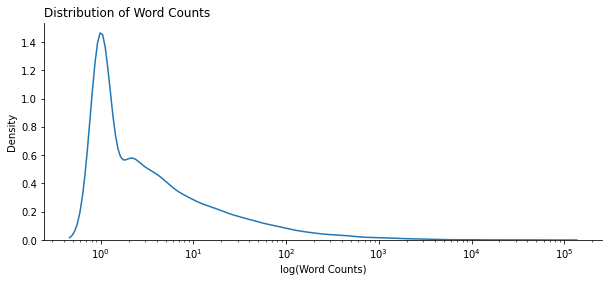

In [15]:
word_counts = processor.count_words()
word_counts = pd.Series(word_counts).sort_values(ascending=False)
word_counts = word_counts.drop([processor.end_token, processor.start_token, processor.fill_token])
#word_counts = np.log(word_counts)

fig = plt.subplots(figsize=(10, 4))
p = sns.kdeplot(word_counts, log_scale=True)
p.set_title('Distribution of Word Counts', loc='left')
p.set_xlabel('log(Word Counts)')
sns.despine()

plt.show()

**Beschreibung**:

Man kann hier eine Long-Tail Distribution sehen, die über eine starke Rechtsschiefe verfügt. Diese Rechtssschiefe ist ein Zeichen dafür, dass die meisten Wörter wenige Wordcounts haben, wobei es vereinzelte Wörter gibt die sehr oft vorkommen und die Verteilung so in die breite ziehen. Bei diesem Beispiel habe ich eine Logtransformation angewendet um zu schauen.

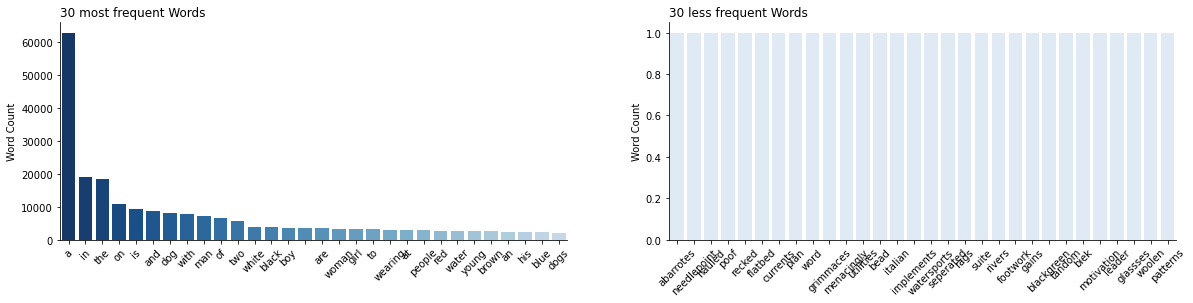

In [16]:
n = 30
word_counts = processor.count_words()
word_counts = pd.Series(word_counts).sort_values(ascending=False)
word_counts = word_counts.drop([processor.end_token, processor.start_token, processor.fill_token])
frequent_words = word_counts.head(n)

fig = plt.subplots(figsize=(20, 4))
plt.subplot(1,2,1)
p = sns.barplot(x=frequent_words.index, y=frequent_words, palette=sns.color_palette('Blues_r', n+10)[:n])
p.set_title(f'{n} most frequent Words', loc='left')
p.set_ylabel('Word Count')
plt.xticks(rotation=45)
sns.despine()

plt.subplot(1,2,2)
not_frequent_words = word_counts.tail(n)
p = sns.barplot(x=not_frequent_words.index, y=not_frequent_words, color=sns.color_palette('Blues_r', n)[-4])
p.set_title(f'{n} less frequent Words', loc='left')
p.set_ylabel('Word Count')
plt.xticks(rotation=45)
sns.despine()

plt.show()

**Beschreibung:**

Auc hier kann man die Rechtsshiefe Form der oberen Verteilung bereits erkennen. Dabei sieht man dass Füllwörter und Präppositionen an erster Stelle auftauchen, was auch so zu erwarten war. Sehr interessant sind Wörter die danach auftauche wie: man, Two, black, woman, girl etc. Dies gibt bereits einen kleinen Aufschluss darüber was auf den Bildern mehrheitlih zu sehen ist. Ein Entfernen der oft vorkommenden Wörter macht denke ich nicht viel sinn, da diese Wörter gebraucht werden, um anständige Sätze zu bilden.

Im rechten Plot sind die seltensten Wörter zu sehen, die sich natürlich im Plot stets unterscheiden, da alle meistens nur einmal auftauchen. Die Wörter sind wurden sehr selten zur Beschreibung der Bilder gebraucht. Daher ist daraus zu schliessen, dass diese Bilder nur einmal im Datensatz auftauchen. Es könnte durchaus sinn machen die wenigvorkommenden Wörter zu löschen, da vermutlich die Datengrundlage zu klein ist, um hier ein Modell anzulernen.

In [17]:
word_counts[word_counts == 1].shape

(3582,)

Wir sehen, dass wir sehr viele Wörter haben, die nur einmal in den Daten vorkommen und wir deshalb auf ein Entfernen verzichten, da wir sonst einen riesigen Informationsverlust zu verzeichnen haben.

In [18]:
processor = TextHandler(n_processes=7, unknown_threshold=None)

In [19]:
processor.fit(image_captions['caption'].tolist())

In [20]:
transformed_sentences = processor.transform(image_captions['caption'].tolist())
transformed_sentences[:2]

[tensor([ 1,  5,  6,  7,  5,  8,  9, 10, 11, 12,  5, 13, 14, 15,  7, 16, 17, 18,
          2,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4]),
 tensor([ 1,  5, 19, 20, 21,  5, 22, 23,  2,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4])]

In [21]:
processor.inverse_transform(transformed_sentences)[:2]

['<START> a child in a pink dress is climbing up a set of stairs in an entry way <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> a girl going into a wooden building <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']

In [22]:
example = processor.transform(['My name is Simon and i like deep learning .'])
example

tensor([   1, 8719, 7527,   10,    3,   32, 3490, 1309,  726, 4539,    2,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4])

In [23]:
processor.inverse_transform([example])

['<START> my name is <UNK> and i like deep learning <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']

Wie man an dieser Aussage sehen kann wurde das Neue Wort, dass noch nicht in den Daten drinnen war als `<UNK>` gekennzeichnet, was die Abk. unbekannt kennzeichnet.

In [24]:
embed_dim = max(list(processor.text_dict.values()))
embedding = nn.Embedding(embed_dim+1, 3)

In [25]:
stacked_transformed_sentences = torch.stack(transformed_sentences)

In [26]:
stacked_transformed_sentences[0:2]

tensor([[ 1,  5,  6,  7,  5,  8,  9, 10, 11, 12,  5, 13, 14, 15,  7, 16, 17, 18,
          2,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4],
        [ 1,  5, 19, 20, 21,  5, 22, 23,  2,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4]])

In [27]:
_ = embedding(stacked_transformed_sentences)

## Loading Data

In [28]:
import os
import pandas as pd
from torchvision.io import read_image
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [29]:
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [30]:
tokenizer('Hello my name is simon')

['Hello', 'my', 'name', 'is', 'simon']

In [31]:
def yield_tokens(L: list, tokenizer):
    for s in L:
        yield tokenizer(s)

# Building Vocab
vocab = build_vocab_from_iterator(yield_tokens(L=image_captions['caption'].tolist(), tokenizer=tokenizer), 
                                  specials=['<UNK>', '<PAD>', '<START>', '<END>'])

In [32]:
# Test vocab
vocab['hello']

3855

In [128]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, annotations_file, img_dir, annot_transform=None, image_transform=None):
        self.annotation_file = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.annot_transform = annot_transform
        self.image_transform = image_transform

    def __len__(self):
        return len(self.annotation_file)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
                
        img_path = os.path.join(self.img_dir, self.annotation_file.iloc[idx, 0])
        image = read_image(img_path)
        image = image.type(torch.float32)
        label = self.annotation_file.iloc[idx, 1]
        if self.image_transform:
            image = self.image_transform(image)
        if self.annot_transform:
            label = self.annot_transform([label])
        return image, label

In [129]:
image_transforms = Compose([Resize(256), 
                            CenterCrop(224), 
                            Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])])

In [130]:
train_dataset = CustomDataset(annotations_file='./data/train_captions.csv', img_dir='./data/train/', 
                              annot_transform=processor.transform, image_transform=image_transforms)
val_dataset = CustomDataset(annotations_file='./data/val_captions.csv', img_dir='./data/val/', 
                              annot_transform=processor.transform, image_transform=image_transforms)
test_dataset = CustomDataset(annotations_file='./data/test_captions.csv', img_dir='./data/test/', 
                                annot_transform=processor.transform, image_transform=image_transforms)

In [137]:
def test_dataloaders(dloaders: list):
    print(10*'=', 'Test Loader', 10*'=')
    for i, dloader in enumerate(dloaders):
        try:
            img, labels = next(iter(dloader))
            assert type(img) == torch.Tensor
            assert type(labels) == torch.Tensor
            print(f'Test Successfull Loader {i}')
        except Exception as e:
            print(e, f'Not right Dtypes returned for Loader {i}')
            
    print(10*'=', 'Test End', 10*'=')


In [138]:
dataloader_train = DataLoader(dataset=train_dataset, batch_size=1, num_workers=1)
dataloader_val = DataLoader(dataset=val_dataset, batch_size=1, num_workers=1)
dataloader_test = DataLoader(dataset=test_dataset, batch_size=1, num_workers=1)

In [139]:
test_dataloaders([dataloader_train, dataloader_val, dataloader_test])

========== Test Loader ==========
Test Successfull Loader 0
Test Successfull Loader 1
Test Successfull Loader 2
========== Test End ==========


# Modeling

In [72]:
from program.model import train_network, network_predict

In [39]:
# Load CNN 
resnet = models.resnet50(pretrained=False)
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [152]:
class ImageEncoderCNN(nn.Module):
    """Image Encoder with ResNet Architecture"""
    
    def __init__(self, embed_size: int, pretrained: bool = False):
        """
        Image Encoder Network.
        
        arguments:
        --------------
        embed_size: int
            Size of embedding for decoder input
        
        pretrained: bool
            True if network should be pretrained or trained as new.

        """
        super().__init__()
        self.is_pretrained = pretrained
        self.resnet = models.resnet50(pretrained=pretrained)
        self.resnet.fc = nn.Linear(in_features=2048, out_features=embed_size, bias=True)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        if self.is_pretrained:
            self.resnet.fc.weights.requires_grad = True
            self.resnet.fc.bias.requires_grad = True
        x = self.resnet(x)
        x = self.relu(x)
        
        return x.view(x.size(0), -1)
    
class DecoderRNN(nn.Module):
    """Caption Decoder with RNN architecture"""
    
    def __init__(self, embed_size: int, vocab_size: int, 
                 hidden_state: int, num_layers: int):
        """
        Caption Decoder which generates word according to givne hidden state input of encoded 
        image.
        
        arguments:
        -------------
        embed_size: int
            Dim of the word embeddings
        
        vocab_size: int
            size of the vocabulary written with tokenizer
                                   
        hidden_state: int
            Amount of hidden states in RNN (max word lenghts?)
            
        num_layers: int
            Amount of stacked RNN cells on top of each other.
            
        """
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_state, 
                            num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_state, out_features=vocab_size)
        
    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        features = features.unsqueeze(1)
        embeddings = torch.cat((features, embeddings[:, :-1,:]), dim=1)
        hidden, cell = self.lstm(embeddings)
        out = self.linear(hidden)
        
        return out
    
class EncoderDecoder(nn.Module):
    
    def __init__(self, embed_size: int, vocab_size: int, 
                 hidden_state: int, num_layers: int):
        """
        Combines CNN Image Decoder and adds an RNN Captions Generator.
        
        arguments:
        -------------
        embed_size: int
            Dim of the word embeddings
        
        vocab_size: int
            size of the vocabulary written with tokenizer
                                   
        hidden_state: int
            Amount of hidden states in RNN (max word lenghts?)
            
        num_layers: int
            Amount of stacked RNN cells on top of each other.
                    
        """
        super().__init__()
        self.encoder = ImageEncoderCNN(embed_size=embed_size)
        self.decoder = DecoderRNN(embed_size=embed_size, vocab_size=vocab_size, 
                                  hidden_state=hidden_state, num_layers=num_layers)
    
    def forward(self, images, captions):
        image_features = self.encoder(images)
        out = self.decoder(image_features, captions)
        
        return out

In [153]:
dataloader_train = DataLoader(dataset=train_dataset, batch_size=10, num_workers=1)
dataloader_val = DataLoader(dataset=val_dataset, batch_size=10, num_workers=1)
dataloader_test = DataLoader(dataset=test_dataset, batch_size=10, num_workers=1)

In [154]:
# Vocab Params
EMBED_SIZE = 50
VOCAB_SIZE = max(list(processor.text_dict.values()))

# RNN Params
HIDDEN_SIZE = processor.longest_word
NUM_LAYERS = 1

encoder = ImageEncoderCNN(embed_size=EMBED_SIZE, pretrained=False)
decoder = DecoderRNN(embed_size=EMBED_SIZE, vocab_size=VOCAB_SIZE, hidden_state=HIDDEN_SIZE, 
                     num_layers=NUM_LAYERS)
encoderdecoder = EncoderDecoder(embed_size=EMBED_SIZE, vocab_size=VOCAB_SIZE, 
                                hidden_state=HIDDEN_SIZE, num_layers=NUM_LAYERS)

In [155]:
# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

params = list(encoderdecoder.encoder.parameters()) + list(encoderdecoder.decoder.embedding.parameters()) +  list(encoderdecoder.decoder.lstm.parameters()) + list(encoderdecoder.decoder.linear.parameters())

optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [156]:
def train_network(model, criterion, optimizer, n_epochs, dataloader_train, 
                  dataloader_test=None):
    """
    Trains a neural Network with given inputs and parameters.
    
    params:
    -------------
    model: 
        Neural Network class Pytorch  
        
    criterion: 
        Cost-Function used for the network optimizatio
        
    optimizer: 
        Optmizer for the network
        
    n_epochs: 
        Defines how many times the whole dateset should be fed through the network
        
    dataloader_train: 
        Dataloader with the batched dataset
        
    dataloader_test:
        Dataloader test with the batched dataset used for test loop. If None -> No eval loop
        
    returns:
    ---------------
    model:
        trained model
    losses:
        Losses over each iteration  
    accuracy:
        Accuracy score on trainset at acc_at_iter iteration
    """
    y_pred, y_true = torch.Tensor(), torch.Tensor()
    train_losses, eval_losses = [], []
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(dev)
    criterion.to(dev)

    model.train()
    train_acc = 0
    overall_length = len(dataloader_train)
    with tqdm(total=n_epochs*overall_length) as pbar:
        for epoch in range(n_epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            for i, data in enumerate(dataloader_train):
                # get the inputs; data is a list of [inputs, labels]
                images, captions = data
                images, captions = images.to(dev), captions.to(dev)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(images, captions)
                loss = criterion(outputs.contiguous().view(-1, VOCAB_SIZE), captions.view(-1))
                loss.backward()
                optimizer.step()
                                    
                # calc and print stats
                train_losses.append(loss.item())
                running_loss += loss.item()                
                
                pbar.set_description(f'Epoch: {epoch+1}/{n_epochs} // Running Loss: {np.round(running_loss, 3)} ')
                pbar.update(1)
                
            if dataloader_test:
                length_dataloader_test = len(dataloader_test)
                for i, data in enumerate(dataloader_test):
                    pbar.set_description(f'Epoch: {epoch+1}/{n_epochs} // Eval-Loop: {i+1}/{length_dataloader_test}')
                    model.eval()
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    inputs, labels = inputs.to(dev), labels.to(dev)
                    # forward + backward + optimize
                    outputs = model(inputs)
                    eval_loss = criterion(outputs, labels)
                    eval_losses.append(eval_loss.item())
                    model.train()
                            
    return model, dict(train=train_losses, test=eval_losses)

In [157]:
train_network(model=encoderdecoder, criterion=criterion, optimizer=optimizer, n_epochs=1, dataloader_train=dataloader_train)

  0%|          | 0/3046 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Sources

https://arxiv.org/pdf/1411.4555.pdf

https://www.kaggle.com/mdteach/image-captioning-with-out-attention-pytorchhttps://www.kaggle.com/mdteach/image-captioning-with-out-attention-pytorch

https://medium.com/@stepanulyanin/captioning-images-with-pytorch-bc592e5fd1a3

https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

https://medium.com/@deepeshrishu09/automatic-image-captioning-with-pytorch-cf576c98d319